In [2]:
import torch
import torchvision
import os
import cv2
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision import transforms
from sklearn import model_selection
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
from skimage import transform
from torch.optim import lr_scheduler
import logging
import copy
import time
from torch.autograd import Variable
from torchsummary import summary
from timeit import default_timer as timer
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
a = np.array([1,2,3])
print(np.max(a))

cuda
3


In [4]:
class MudraDataset(Dataset):
    def __init__(self, root_dir, state='All', transform=None):
        #"""
        #Args:
            #csv_files (string): Path to the csv file with annotations
            #root_dir (string): Directory with all the images
            #transform (callable, optional): Optional transform to be applied on a sample
        #"""
        #self.mudraJoints = pd.read_csv(csv_file)
        self.state = state
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.X_data = []
        self.Y_data = []
        
        if os.path.isdir(root_dir):
            for dirs in os.listdir(root_dir):
                #print(dirs)
                full_path = os.path.join(root_dir, dirs)
                csv_path = os.path.join(full_path, 'Annotation.csv')
                csv_file = pd.read_csv(csv_path)
                for i, row in csv_file.iterrows():
                    img_path = os.path.join(full_path, row[0])
                    #print(img_path)
                    image = img_path
                    self.X_data.append(image)
                    jointAngle = row[1:]
                    jointAngle = np.array([jointAngle])
                    jointAngle = jointAngle.astype('float')
                    if np.max(jointAngle) > 0:
                        jointAngle = jointAngle / np.max(jointAngle)
                    self.Y_data.append(jointAngle)
                    #sample = {'image': image, 'jointAngle': jointAngle}
                    #self.data.append(sample)

        X_train, X_test, Y_train, Y_test = model_selection.train_test_split(self.X_data,
                                                self.Y_data, test_size=0.25, random_state=42)
        if state == 'Train':    
            self.X_data, self.Y_data = X_train, Y_train
        elif state == 'Test':
            self.X_data, self.Y_data = X_test, Y_test
    
    def __len__(self):
        return len(self.X_data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        sample = {'image': cv2.imread(self.X_data[idx]), 'jointCood': self.Y_data[idx]}
        
        if self.transform:
            sample = self.transform(sample)
        return sample

In [5]:
#Data Preprocessing Rescale, RandomCrop, and ToTensor
class Rescale(object):
    #Args:
    #output_size (tuple or int): Desired output size. If tuple, output is matched to output size. It int, smaller of
    #image edges is matched to output_size keeping aspect ratio the same
    
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image, joints = sample['image'], sample['jointCood']
        #print(image)
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        
        return {'image': img, 'jointCood': joints}
    
class RandomCrop(object):
    #Args:
    #output_size (tuple or int): Desired output size. If int, square crop is made

    def __init__(self, output_size):
        assert isinstance(output_size, (tuple, int))

        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, joints = sample['image'], sample['jointCood']
        #print(image)
        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]

        return {'image': image, 'jointCood': joints}

class ToTensor(object):
    #Convert numpy array image to tensor image

    def __call__(self, sample):
        image, joints = sample['image'], sample['jointCood']

        #swap color axis because
        #numpy image: H * W * C
        #torch image: C * H * W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image).to(torch.float), 'jointCood': torch.from_numpy(joints).to(torch.float)}

In [6]:
scale = Rescale((227,227))
#composed = transforms.Compose([scale, ToTensor()])

train_dataset = MudraDataset(root_dir='Mudra Dataset/Single hand', state='Train',
                                  transform=transforms.Compose([Rescale((227,227)), ToTensor()]))

test_dataset = MudraDataset(root_dir='Mudra Dataset/Single hand', state='Test',
                                  transform=transforms.Compose([Rescale((227,227)), ToTensor()]))

val_dataset = MudraDataset(root_dir='Mudra Dataset/Single hand', state='Train',
                                  transform=transforms.Compose([Rescale((227,227)), ToTensor()]))

In [7]:
def data_loader(batch_size, random_seed=42, valid_size=0.1, shuffle=True, test=False):
    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    
    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    
    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
    valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=valid_sampler)
    
    if test:
        return torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle)
    else:
        return (train_loader, valid_loader)

In [8]:
train_loader, valid_loader = data_loader(batch_size=16)
test_loader = data_loader(batch_size=1, test=True)

In [9]:
class Inception(nn.Module):
    
    def __init__(self, in_channels=3, use_auxiliary=True, num_classes=1000):
        super(Inception, self).__init__()
        
        self.conv1 = ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3)
        self.conv2 = ConvBlock(64, 192, kernel_size=3, stride=1, padding=1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.avgpool = nn.AvgPool2d(kernel_size=7, stride=1)
        
        self.dropout = nn.Dropout(0.4)
        self.linear1 = nn.Linear(4096, 1024)
        self.linear2 = nn.Linear(1024,num_classes)
        
        self.use_auxiliary = use_auxiliary
        if use_auxiliary:
            self.auxiliary4a = Auxiliary(512, num_classes)
            self.auxiliary4d = Auxiliary(528, num_classes)
        
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

    def forward(self, x):
        y = None
        z = None
        
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.maxpool(x)
        
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool(x)
        
        x = self.inception4a(x)
        if self.training and self.use_auxiliary:
            y = self.auxiliary4a(x)
        
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.use_auxiliary:
            z = self.auxiliary4d(x)
        
        x = self.inception4e(x)
        x = self.maxpool(x)
        
        x = self.inception5a(x)
        x = self.inception5b(x)
        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.dropout(x)
        
        x = self.linear1(x)
        x = self.linear2(x)
        
        return x, y, z

In [10]:
class ConvBlock(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

In [11]:
class InceptionBlock(nn.Module):
    
    def __init__(self, im_channels, num_1x1, num_3x3_red, num_3x3, num_5x5_red, num_5x5, num_pool_proj):
        super(InceptionBlock, self).__init__()
        
        self.one_by_one = ConvBlock(im_channels, num_1x1, kernel_size=1)
        
        self.tree_by_three_red = ConvBlock(im_channels, num_3x3_red, kernel_size=1)  
        self.tree_by_three = ConvBlock(num_3x3_red, num_3x3, kernel_size=3, padding=1)
        
        self.five_by_five_red = ConvBlock(im_channels, num_5x5_red, kernel_size=1)
        self.five_by_five = ConvBlock(num_5x5_red, num_5x5, kernel_size=5, padding=2)
        
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.pool_proj = ConvBlock(im_channels, num_pool_proj, kernel_size=1)
         
    def forward(self, x):
        x1 = self.one_by_one(x)
        
        x2 = self.tree_by_three_red(x)
        x2 = self.tree_by_three(x2)
        
        x3 = self.five_by_five_red(x)
        x3 = self.five_by_five(x3)
        
        x4 = self.maxpool(x)
        x4 = self.pool_proj(x4)
        
        x = torch.cat([x1, x2, x3, x4], 1)
        return x

In [12]:
class Auxiliary(nn.Module):
    
    def __init__(self, in_channels, num_classes):
        super(Auxiliary, self).__init__()
        self.avgpool = nn.AvgPool2d(kernel_size=5, stride=3)
        self.conv1x1 = ConvBlock(in_channels, 128, kernel_size=1)
        
        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        
        self.dropout = nn.Dropout(0.7)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.avgpool(x)
        x = self.conv1x1(x)
        x = x.reshape(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [12]:
model = Inception(use_auxiliary=False, num_classes=14)
model.to(device)

Inception(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear1): Linear(in_features=4096, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=14, bias=True)
  (inception3a): InceptionBlock(
    (one_by_one): ConvBlock(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [55]:
criterion = nn.MSELoss()
optimizer_ft = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [52]:
def train(model, criterion, optimizer, train_loader, valid_loader, save_file_name, 
         max_epochs_stop=3, n_epochs=20, print_every=1):
    #Early stopping initialization
    epochs_no_improve = 0
    valid_loss_min = np.inf

    valid_max_acc = 0
    history = []

    #Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting training from scratch.\n')
    
    overall_start = timer()
    
    #Main loop
    for epoch in range(n_epochs):
        #keep track of training and validation loss each epoch
        train_loss=0.0
        valid_loss=0.0
        
        train_acc=0
        valid_acc=0
        
        #Set to training
        model.train()
        start = timer()
        
        #Training loop
        for ii, sample in enumerate(train_loader):
            #Tensor to GPU
            if device:
                data, target = sample['image'].to(device), sample['jointCood'].to(device)
            
            #Clear gradients
            optimizer.zero_grad()
            output, aux1, aux2 = model(data)
            
            #print(output)
            #print(target)
            #Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()
            
            #Update the parameters
            optimizer.step()
            
            #Track train loss by multiplying average loss by number of example in batch
            train_loss += loss.item() * data.size(0)
            
            #Track training progress
            print(f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.'
                 , end='\r')
        #After training loop ends, start validation
        else:
            model.epochs += 1
            
            #Don't need to keep track of the gradients
            with torch.no_grad():
                #Set to evaluation mode
                model.eval()
                
                #Validation loop
                for ii, sample in enumerate(valid_loader):
                    data = sample['image']
                    target = sample['jointCood']
                    
                    if device:
                        data, target = data.cuda(), target.cuda()
                    
                    #Forward pass
                    output, aux1, aux2 = model(data)
                    
                    #Validation loss
                    loss = criterion(output, target)
                    #print(output)
                    valid_loss += loss.item() * data.size(0)
                    
                #Calculate average losses
                train_loss = train_loss / len(train_loader)
                valid_loss = valid_loss / len(valid_loader)
                
                history.append([train_loss, valid_loss])
                
                #Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                
                #Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    #Save model
                    torch.save(model.state_dict(), save_file_name)
                    #Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    best_epoch = epoch
                
                #Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    #Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )
                        
                        #Load the best state dict.
                        model.load_state_dict(torch.load(save_file_name))
                        #Attach the optimizer
                        model.optimizer = optimizer
                        
                        #Format history
                        history = pd.DataFrame(history,
                                              columns=['train_loss', 'valid_loss'])
                    return model, history
    #Attach the optimizer
    model.optimizer = optimizer
    #Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    #Format history
    history = pd.DataFrame(history,
                          columns=['train_loss', 'valid_loss'])
    return model, history

In [28]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
save_file_name = 'googleNetRegressor.pth'

In [53]:
model, history = train(
                    model, 
                    criterion,
                    optimizer,
                    train_loader,
                    valid_loader,
                    save_file_name=save_file_name,
                    max_epochs_stop=5,
                    n_epochs=100,
                    print_every=1)

Model has been trained for: 0 epochs.



/home/soumen/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([16, 1, 14])) that is different to the input size (torch.Size([16, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/soumen/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([12, 1, 14])) that is different to the input size (torch.Size([12, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


/home/soumen/anaconda3/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([3, 1, 14])) that is different to the input size (torch.Size([3, 14])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Epoch: 0 	Training Loss: 5.6884 	Validation Loss: 5.5941
Epoch: 1	100.00% complete. 374.42 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 5.6935 	Validation Loss: 5.5868
Epoch: 2	100.00% complete. 376.74 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 5.6983 	Validation Loss: 5.5912


In [64]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc =0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(train_loader)
    val_batches = len(valid_loader)
    
    print(train_batches, val_batches)
    
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        print("{}/{}".format(epoch, num_epochs))
        print("-"*10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        for i, data in enumerate(train_loader):
            image, label = data['image'], data['jointCood']
            
            if device:
                image, label = Variable(image.cuda(), volatile = True), Variable(label.cuda(), volatile = True)
            else:
                image, label = Variable(image), Variable(label)
            
            optimizer.zero_grad()
            #print(image.shape)
            image = torch.cuda.FloatTensor(image)
            outputs, aux1, aux2 = model(image)
            #print(outputs.data)
            _, preds = torch.max(outputs.data, 1)
            #print(outputs)
            #print(label)
            loss = criterion(outputs, label)
            loss.backward()
            optimizer.step()
            
            loss_train += torch.mean(loss).item()
            #print(preds)
            #print(label.data)
            acc_train += torch.sum(outputs.data == label.data)
            
            del image, label, outputs, preds
            torch.cuda.empty_cache()
            
        print()
        
        avg_loss = loss_train / train_batches
        avg_acc = acc_train / train_batches
        
        model.train(False)
        model.eval()
        
        for i, data in enumerate(valid_loader):
            image, label = data['image'], data['jointCood']
            
            if device:
                image, label = Variable(image.cuda(), volatile = True), Variable(label.cuda(), volatile = True)
            else:
                image, label = Variable(image, volatile=True), Variable(label, volatile=True)
            
            optimizer.zero_grad()
            outputs, aux1, aux2 = model(image)
            #print(outputs.data)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs.data, label)
            
            loss_val += torch.mean(loss).item()
            acc_val += torch.sum(outputs.data == label.data)
            
            del image, label, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / val_batches
        avg_acc_val = acc_val / val_batches
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [65]:
model = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=100)

587 66
0/100
----------


/tmp/ipykernel_63664/3900934191.py:32: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image, label = Variable(image.cuda(), volatile = True), Variable(label.cuda(), volatile = True)


/tmp/ipykernel_63664/3900934191.py:68: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image, label = Variable(image.cuda(), volatile = True), Variable(label.cuda(), volatile = True)



Epoch 0 result: 
Avg loss (train): 0.3395
Avg acc (train): 0.0000
Avg loss (val): 0.2166
Avg acc (val): 0.0000
----------

1/100
----------


Epoch 1 result: 
Avg loss (train): 0.1995
Avg acc (train): 0.0000
Avg loss (val): 0.1938
Avg acc (val): 0.0000
----------

2/100
----------


Epoch 2 result: 
Avg loss (train): 0.1930
Avg acc (train): 0.0000
Avg loss (val): 0.4751
Avg acc (val): 0.0000
----------

3/100
----------


Epoch 3 result: 
Avg loss (train): 0.1931
Avg acc (train): 0.0000
Avg loss (val): 0.1942
Avg acc (val): 0.0000
----------

4/100
----------


Epoch 4 result: 
Avg loss (train): 0.1900
Avg acc (train): 0.0000
Avg loss (val): 0.1940
Avg acc (val): 0.0000
----------

5/100
----------


Epoch 5 result: 
Avg loss (train): 0.1920
Avg acc (train): 0.0000
Avg loss (val): 0.1953
Avg acc (val): 0.0000
----------

6/100
----------


Epoch 6 result: 
Avg loss (train): 0.1893
Avg acc (train): 0.0000
Avg loss (val): 0.1955
Avg acc (val): 0.0000
----------

7/100
----------


Epoch



Epoch 58 result: 
Avg loss (train): 0.1886
Avg acc (train): 0.0000
Avg loss (val): 0.1928
Avg acc (val): 0.0000
----------

59/100
----------


Epoch 59 result: 
Avg loss (train): 0.1886
Avg acc (train): 0.0000
Avg loss (val): 0.1922
Avg acc (val): 0.0000
----------

60/100
----------


Epoch 60 result: 
Avg loss (train): 0.1886
Avg acc (train): 0.0000
Avg loss (val): 0.1922
Avg acc (val): 0.0000
----------

61/100
----------


Epoch 61 result: 
Avg loss (train): 0.1886
Avg acc (train): 0.0000
Avg loss (val): 0.1928
Avg acc (val): 0.0000
----------

62/100
----------


Epoch 62 result: 
Avg loss (train): 0.1886
Avg acc (train): 0.0000
Avg loss (val): 0.1928
Avg acc (val): 0.0000
----------

63/100
----------


Epoch 63 result: 
Avg loss (train): 0.1887
Avg acc (train): 0.0000
Avg loss (val): 0.1923
Avg acc (val): 0.0000
----------

64/100
----------


Epoch 64 result: 
Avg loss (train): 0.1887
Avg acc (train): 0.0000
Avg loss (val): 0.1934
Avg acc (val): 0.0000
----------

65/100
---

In [168]:
model = Inception(use_auxiliary=False, num_classes=14)
model.load_state_dict(torch.load('GoogleNetRegressor.pth'))
model.eval()

Inception(
  (conv1): ConvBlock(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (conv2): ConvBlock(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (avgpool): AvgPool2d(kernel_size=7, stride=1, padding=0)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear1): Linear(in_features=4096, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=14, bias=True)
  (inception3a): InceptionBlock(
    (one_by_one): ConvBlock(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [169]:
class GradCamModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.gradients = None
        self.tensorhook = []
        self.layerhook = []
        self.selected_out = None
        
        self.pretrained = model
        self.layerhook.append(self.pretrained.inception3b.register_forward_hook(self.forward_hook()))
        
        for p in self.pretrained.parameters():
            p.requires_grad = True
    
    def activations_hook(self, grad):
        print('Activation hook')
        self.gradients = grad
    
    def get_act_grads(self):
        print('Get_act_grads')
        return self.gradients
    
    def forward_hook(self):
        print('forward hook')
        def hook(module, inp, out):
            print('hook')
            self.selected_out = out
            self.tensorhook.append(out.register_hook(self.activations_hook))
        return hook
    
    def forward(self, x):
        print('forward')
        out, a1, a2 = self.pretrained(x)
        return out, self.selected_out

In [170]:
gcmodel = GradCamModel().to(device)

forward hook


In [154]:
for i, sample in enumerate(test_loader):
    testimg, label = sample['image'], sample['jointCood']

In [26]:
from skimage.transform import resize
testimg = resize(testimg, (227,227), preserve_range=True)
testimg = np.expand_dims(testimg.transpose((2,0,1)),0)
testimg /= 255.0
#mean = np.array([0.485, 0.456, 0.406]).reshape((1,3,1,1))
#std = np.array([0.229, 0.224, 0.225]).reshape((1,3,1,1))
#testimg = (testimg - mean)/std
testimg = torch.from_numpy(testimg).to(device, torch.float32)

AttributeError: 'torch.dtype' object has no attribute 'char'

In [171]:
out, acts = gcmodel(testimg.to(device))
print(acts.shape)
print(out.shape)

forward
hook
torch.Size([1, 480, 29, 29])
torch.Size([1, 14])


In [172]:
acts = acts.detach().cpu()
criterion = nn.MSELoss()
print(acts.shape)

torch.Size([1, 480, 29, 29])


In [173]:
label = label.reshape([label.shape[0],label.shape[2]])
print(label.shape)

torch.Size([1, 14])


In [174]:

loss = criterion(out, label.to(device))
loss.backward()

grads = gcmodel.get_act_grads().detach().cpu()


pooled_grads = torch.mean(grads, dim=[0,2,3]).detach().cpu()
print(pooled_grads)

for i in range(acts.shape[1]):
    acts[:,i,:,:] *= pooled_grads[i]

Activation hook
Get_act_grads
tensor([ 6.2111e-07,  2.4832e-07, -4.4469e-08,  7.3797e-07,  3.5133e-06,
         2.9076e-06, -9.6749e-07, -4.6356e-06, -2.3809e-07, -1.3994e-06,
        -3.8298e-06,  5.3833e-06, -2.4441e-06,  3.7360e-06, -5.8154e-07,
         3.3721e-06, -3.2895e-06, -4.4601e-08, -1.2590e-06, -1.0870e-06,
        -4.7588e-06,  1.0335e-06, -6.2113e-06, -2.3818e-06, -2.3625e-06,
         1.9284e-06, -1.2845e-06,  5.2052e-06, -1.1214e-06,  3.4366e-06,
        -4.5924e-06,  3.4368e-06, -4.8764e-06, -7.0153e-07, -2.1602e-06,
         1.3799e-06, -4.0292e-07, -1.6419e-06, -2.9287e-07, -4.4972e-06,
         2.8626e-06,  2.7519e-06, -4.8697e-06,  1.0717e-06, -2.9961e-06,
         2.2689e-06,  3.5510e-06,  1.6187e-06,  4.0291e-06,  1.6814e-07,
         2.5634e-07, -6.5133e-07,  3.3935e-06, -5.8101e-06,  1.8738e-06,
         5.3024e-06,  4.4801e-06, -5.9558e-07, -4.0265e-06, -6.3642e-06,
         7.5111e-07, -1.7001e-06, -1.0962e-06, -2.8271e-06,  1.4818e-07,
        -5.3357e-06, 

In [175]:
heatmap_j = torch.mean(acts, dim=1).squeeze()

In [176]:
heatmap_j_max = heatmap_j.max(axis=0)[0]

In [177]:
heatmap_j /= heatmap_j_max
print(heatmap_j)

tensor([[ 8.6415e-01,  4.6712e-01,  6.6178e-01,  3.0167e-01,  2.2236e-01,
          4.1002e-01,  8.2898e-02,  1.8908e-01,  2.7561e-01,  1.5541e-01,
          1.4121e-01,  2.2547e-01,  2.9078e-01,  3.9629e-01,  2.1972e-01,
          1.7336e-01,  2.4352e-01,  1.8270e-01,  2.9486e-01,  2.9398e-01,
          2.3533e-01,  1.4246e-01,  2.3846e-01,  5.4223e-01,  4.9293e-01,
          5.5701e-01, -1.1656e-01,  1.0000e+00, -3.4512e-01],
        [ 1.9521e-01,  2.3739e-01, -5.9468e-01, -3.2753e-01, -5.0579e-02,
         -3.4605e-01, -3.9023e-01, -5.4496e-01, -3.9747e-01, -4.1486e-01,
         -5.3394e-01, -6.7912e-01, -2.2450e-01, -5.8775e-02, -1.0278e-01,
         -7.6475e-02, -4.5405e-01, -3.1904e-01, -3.5489e-01, -4.5657e-01,
         -2.4452e-01, -2.1336e-01, -6.0459e-01, -5.4215e-01, -8.5682e-01,
         -1.1569e+00, -1.1685e+00, -1.6158e+00, -3.6752e-01],
        [ 8.1965e-01,  2.9322e-01, -2.2217e-01, -1.7523e-01, -2.6786e-01,
         -3.6233e-01, -4.1000e-01, -6.1764e-01, -2.4287e-01, -

In [178]:
from skimage.transform import resize
heatmap_j = resize(heatmap_j.numpy(),(227,227),preserve_range=True)

In [179]:
import matplotlib as mpl
cmap = mpl.cm.get_cmap('jet',256)
heatmap_j2 = cmap(heatmap_j,alpha = 0.2)

In [180]:
testimg1 = testimg.squeeze(0)
#testimg = transforms.functional.to_pil_image(testimg)
print(testimg1[0].shape)

torch.Size([227, 227])


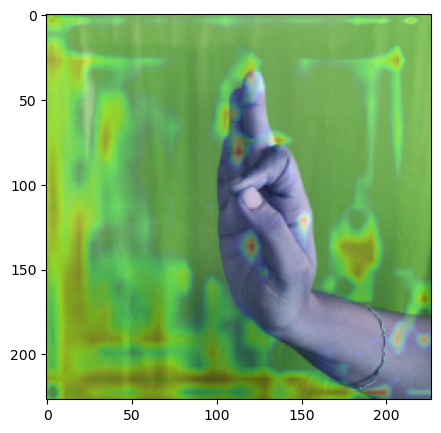

In [181]:
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow(testimg1.permute(1,2,0))
axs.imshow(heatmap_j2)
plt.show()

In [122]:
heatmap_j3 = (heatmap_j > 0.75)
print(heatmap_j3.shape)

(227, 227)


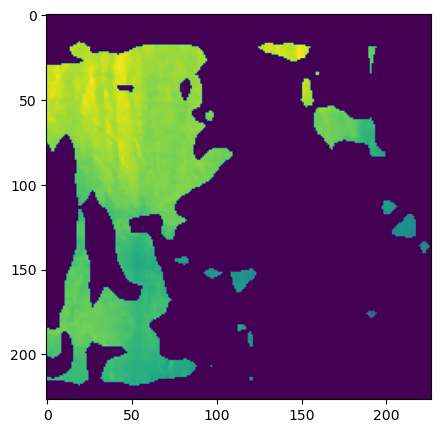

In [125]:
fig, axs = plt.subplots(1,1,figsize = (5,5))
axs.imshow((testimg1[0])*heatmap_j3)
plt.show()